In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 15,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

### Load data and train NB posterior

In [3]:
folder = '../data/'
fn = '201803220946_toy_example_results_N100000M10_k21.0.p'
time_stamp = fn[:fn.find('_')]

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 5
np.random.seed(seed)

In [4]:
# priors 
d_model = d['model_post']
sample_size = d_model['sample_size']
k1, k2, k3 = d_model['k1'], d_model['k2'], d_model['k3']
theta1, theta2, theta3 = d_model['theta1'], d_model['theta2'], d_model['theta3']

prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed)

In [5]:
# generate training data 
ntrain = 100000
params_train = np.vstack((prior_k.rvs(size=ntrain), prior_theta.rvs(size=ntrain))).T
x_train = model_nb.gen(params_train)

sx_train = calculate_stats_toy_examples(x_train)
sx_train_zt, data_norm = normalize(sx_train)
params_train_zt, param_norm = normalize(params_train)

In [6]:
# train the posterior network 
# define a network to approximate the posterior with a MoG 
model_params_mdn = MultivariateMogMDN(ndim_input=2, ndim_output=2, n_hidden_units=10, 
                                      n_hidden_layers=1, n_components=2)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

training: 100%|██████████| 100/100 [05:33<00:00,  3.15s/it]


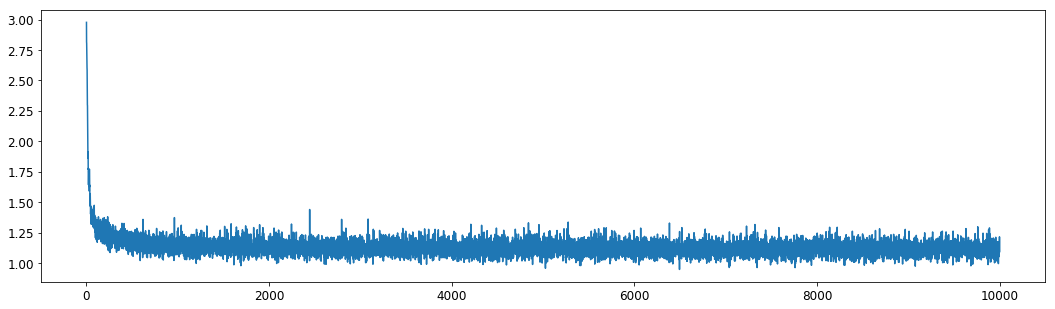

In [7]:
loss_trace = trainer.train(sx_train_zt, params_train_zt, n_epochs=100, n_minibatch=int(sx_train.shape[0] / 100))
plt.figure(figsize=(18, 5))
plt.plot(loss_trace)

## Sample new test data 

In [43]:
ntest = 10000
params_test = np.vstack((prior_k.rvs(size=ntest), prior_theta.rvs(size=ntest))).T
x_test = model_nb.gen(params_test)

In [44]:
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, data_norm)
params_test_zt, _ = normalize(params_test, param_norm)

## Loop over test samples for 
- #### Quantiles 
- #### posterior mean differences 
- #### $D_{KL}$
- #### credible intervals 

In [45]:
mus_hat = []
mus_exact = []
stds_hat = []
stds_exact = []

# quantiles, dkl ratios and credible intervals for every dimension (2)
dkl_ratios = np.zeros((2, ntest))
qis = np.zeros_like(dkl_ratios)
credible_intervals = np.arange(0.05, 1., 0.05)
success_counts = np.zeros((2, credible_intervals.size))

# for every test sample 
with tqdm.tqdm(total=ntest) as pbar: 
    for ii, (thetao_i, sxo_i, xo_i) in enumerate(zip(params_test, sx_test_zt, x_test)): 

        # predict the posterior
        post_hat = model_params_mdn.predict(sxo_i.reshape(1, -1))
        # get dd object 
        post_hat_dd = post_hat.get_dd_object()
        # transform to original parameter range 
        post_hat_or = post_hat_dd.ztrans_inv(param_norm[0], param_norm[1])
        
        # get the mean 
        mus_hat.append(post_hat_or.mean)
        stds_hat.append(post_hat_or.std)

        # get the mean of the exact posterior 
#         post_exact = model_nb.get_exact_posterior(xo_i, prior_k, prior_theta)
#         mus_exact.append(post_exact.mean)
#         stds_exact.append(post_exact.std)
        
        # for every variable, look at the marginal
        # get quantile of theta_o, for each parameter component separately
        thetao_i_zt, _ = normalize(thetao_i, param_norm)
        marginals = post_hat.get_marginals()
        
        for vi, (m, th) in enumerate(zip(marginals, thetao_i_zt)): 
            qis[vi, ii] = m.get_quantile(th)
            success_counts[vi, :] += calculate_credible_interval_counts(m, theta_o=th, 
                                                                          intervals=credible_intervals)            
        pbar.update()

100%|██████████| 10000/10000 [09:14<00:00, 19.05it/s]


In [47]:
ci_probs = success_counts / ntest

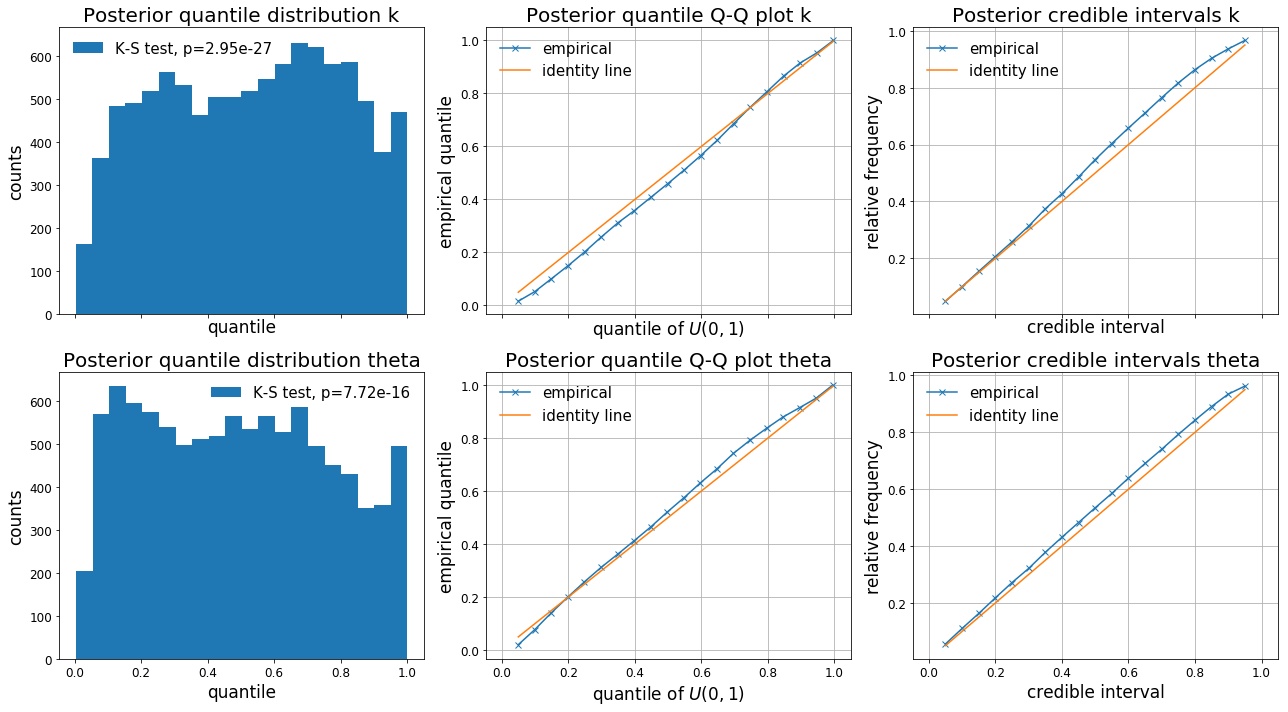

In [48]:
fig2, ax = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey='col')
labels = ['k', 'theta']
for i in range(2):
    (stats, kst_p) = scipy.stats.kstest(qis[i, ], cdf='uniform')
    n, bins, patches = ax[i, 0].hist(qis[i, ], bins=20, label='K-S test, p={:1.3}'.format(kst_p))
    ax[i, 0].set_title('Posterior quantile distribution ' + labels[i])
    ax[i, 0].set_xlabel('quantile')
    ax[i, 0].set_ylabel('counts')
    ax[i, 0].legend()

    ax[i, 1].set_title('Posterior quantile Q-Q plot ' + labels[i])
    sample_quantiles = np.cumsum(n / np.sum(n))
    theo_quantiles = np.cumsum(np.diff(bins))
    
    ax[i, 1].plot(theo_quantiles, sample_quantiles, 'x-', label='empirical')
    ax[i, 1].plot(theo_quantiles, theo_quantiles, label='identity line')
    ax[i, 1].set_ylabel('empirical quantile')
    ax[i, 1].set_xlabel(r'quantile of $U(0, 1)$')
    ax[i, 1].legend()
    ax[i, 1].grid();

    ax[i, 2].set_title('Posterior credible intervals ' + labels[i])
    
    ax[i, 2].plot(credible_intervals, ci_probs[i, ], 'x-', label='empirical')
    ax[i, 2].plot(credible_intervals, credible_intervals, '-', label='identity line')
    ax[i, 2].set_ylabel('relative frequency')
    ax[i, 2].set_xlabel('credible interval')
    ax[i, 2].legend()
    ax[i, 2].grid();
    plt.tight_layout();

In [50]:
fn = time_stamp + 'posterior_checks_2_k2_{}NB.png'.format(int(k2))
fig2.savefig(os.path.join('../figures', fn), dpi=300)